In [1]:
import sys
sys.path.append('..')
from cmost_exposure import load_by_file_prefix, load_by_filepath, scan_headers

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

cmost_dir = '../data'

Load in exposures from the 020321 data set

In [2]:
extra_keys = ['VHIGHTG']

all_files = scan_headers(cmost_dir+'/020321',custom_keys=extra_keys)

# No need to filter further at this stage
all_files.sort('DATE')
all_files.pprint_all()

                   FILEPATH                    READOUTM            DATE            EXPTIME LED   TEMP  CAMERAID      DETID      GAIN VHIGHTG
---------------------------------------------- -------- -------------------------- ------- --- ------- -------- --------------- ---- -------
../data/020321/cmostjpl001_20210203182644.fits  DEFAULT 2021-02-03 18:26:49.293675  1000.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high     2.4
../data/020321/cmostjpl001_20210203182705.fits  DEFAULT 2021-02-03 18:27:12.254249  1975.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high     2.4
../data/020321/cmostjpl001_20210203185558.fits  DEFAULT 2021-02-03 18:56:09.799281  3902.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high     2.5
../data/020321/cmostjpl001_20210203185638.fits  DEFAULT 2021-02-03 18:56:56.544894  6501.0 1.6 140.001 cmostjpl EuropaBSI-1-7-3 high     2.5
../data/020321/cmostjpl001_20210203192604.fits  DEFAULT 2021-02-03 19:26:33.605327 10833.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high     2.6
../data/02032

In [3]:
# Load exposures
exposures = load_by_filepath(all_files['FILEPATH'],custom_keys=extra_keys)

In [4]:
# Define a subframe (region of interest) in the format (x1, x2, y1, y2)
subframe = (2600,2700,200,300)

# Populate arrays for fitting/plotting
n_exp = len(exposures)
exp_times, median, var, vhightg = np.zeros(n_exp), np.zeros(n_exp), np.zeros(n_exp), np.zeros(n_exp)
for i in range(n_exp):
    exp_times[i] = exposures[i].exp_time
    median[i] = exposures[i].get_median(subframe)
    var[i] = exposures[i].get_variance(subframe)
    vhightg[i] = np.float(exposures[i].custom_key_values['VHIGHTG'])

tgvs = np.unique(vhightg)

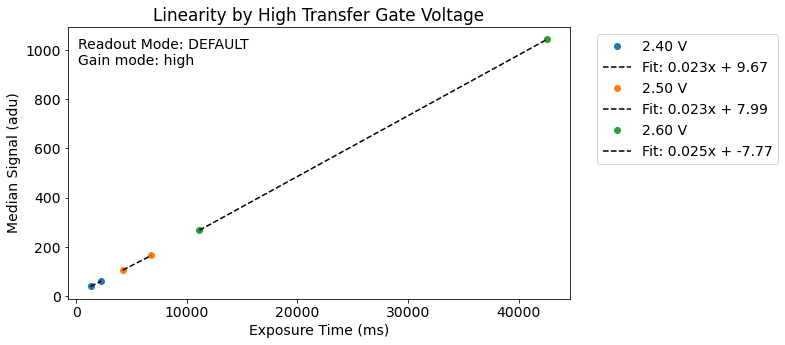

In [5]:
# Plot the linearity curve
plt.figure(figsize=[9,5])
plt.title('Linearity by High Transfer Gate Voltage')

# Add true readout time
timecomp = 300 

for v in tgvs:
    # Plot signal vs exposure time
    exp_time = exp_times[vhightg == v] + timecomp
    signal = median[vhightg == v]
    
    plt.plot(exp_time,signal,'o',label='{:.2f} V'.format(v))
    
    # Linear fit to unsaturated data 
    mask = signal < 24000
    m, b = np.polyfit(exp_time, signal, 1, w=mask)
    poly1d_fn = np.poly1d([m,b]) 
    
    plt.plot(exp_time,poly1d_fn(exp_time),'--k',label='Fit: {:.3f}x + {:.2f}'.format(m, b))

plt.xlabel('Exposure Time (ms)')
plt.ylabel('Median Signal (adu)')

# Plot information
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
info = 'Readout Mode: {}\nGain mode: {}'.format(exposures[0].readout_mode,exposures[0].gain)
plt.annotate(info, xy=(0.02, 0.86), xycoords='axes fraction')

plt.savefig('plots/20210208_Linearity_vs_VHighTG.pdf')
plt.show()
plt.close()

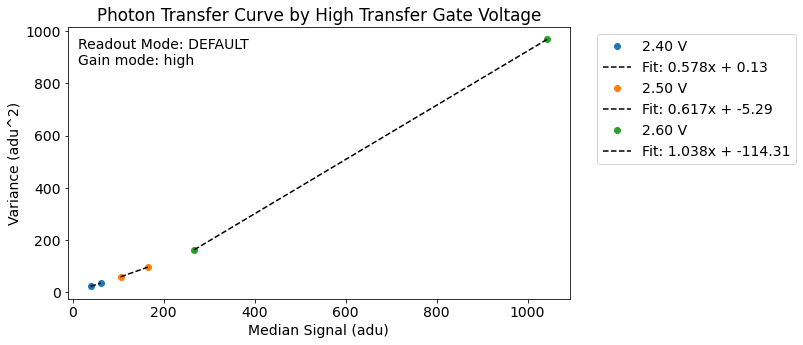

In [6]:
# Plot the photon transfer curve
plt.figure(figsize=[9,5])
plt.title('Photon Transfer Curve by High Transfer Gate Voltage')

for v in tgvs:
    # Plot variance vs signal
    signal = median[vhightg == v]
    variance = var[(vhightg == v) & (var > 0)]
    
    plt.plot(signal,variance,'o',label='{:.2f} V'.format(v))
    
    # Linear fit to lower variance data
    mask = np.array(variance) < 80000
    m, b = np.polyfit(signal, variance, 1, w=mask)
    poly1d_fn = np.poly1d([m, b]) 
    
    plt.plot(signal,poly1d_fn(signal),'--k',label='Fit: {:.3f}x + {:.2f}'.format(m, b))

plt.xlabel('Median Signal (adu)')
plt.ylabel('Variance (adu^2)')

# Plot information
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
info = 'Readout Mode: {}\nGain mode: {}'.format(exposures[0].readout_mode,exposures[0].gain)
plt.annotate(info, xy=(0.02, 0.86), xycoords='axes fraction')

plt.savefig('plots/20210208_PTC_vs_VHighTG.pdf')
plt.show()
plt.close()